In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 50.6 MB/s eta 0:00:00


In [ ]:
#!pip install lazypredict
!pip install lazypredict-nightly

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [ ]:
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [ ]:
import lazypredict
#from lazypredict.Supervised import LazyRegressor
from lazypredict import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Preprocessing and feature engineering of the collected data

In [ ]:
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/bioactivity_data/bioactivity_data_raw.csv

--2024-10-31 18:03:45--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/bioactivity_data/bioactivity_data_raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77794 (76K) [text/plain]
Saving to: ‘bioactivity_data_raw.csv’

bioactivity_data_ra 100%[===================>]  75.97K  --.-KB/s    in 0.04s   

2024-10-31 18:03:46 (2.08 MB/s) - ‘bioactivity_data_raw.csv’ saved [77794/77794]



In [ ]:
df = pd.read_csv("bioactivity_data_raw.csv")
df.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

In [ ]:
# Handling missing data && cleaning
df = df.dropna(subset=['standard_value', 'canonical_smiles'])
df = df.drop_duplicates(['canonical_smiles']).reset_index(drop=True)

In [ ]:
# Removing insignificant element and keeping the largest compound in each SMILES expression
selected_features=["molecule_chembl_id", "canonical_smiles", "standard_value"]
df = df[selected_features]

smileless= df.drop(columns=['canonical_smiles'])

smiles=[]
for i in df['canonical_smiles'].tolist():
  strg= str(i).split(".")
  strg = max(strg,key= len)
  smiles.append(strg)

smiles=pd.DataFrame(data=smiles, columns=["canonical_smiles"])
df = pd.concat([smileless, smiles], axis=1)

### Discretization

Classify bioactivity to active, inactive and intermediate according to the standard value.

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be active while those greater than 10,000 nM will be considered to be inactive. As for those values in between 1,000 and 10,000 nM will be referred to as intermediate.

In [ ]:
# if <= 1000 then active
# if >=10000 then inactive
# otherwise it is intermediate
bioactivity_class=[]
for i in df['standard_value']:
  if float(i) <= 1000:
    bioactivity_class.append("active")
  elif float(i) >= 10000:
    bioactivity_class.append("inactive")
  else:
    bioactivity_class.append("intermediate")
act_series=pd.Series(bioactivity_class, name="class")
df = pd.concat([df, act_series], axis=1)
df.head()

,molecule_chembl_id,standard_value,canonical_smiles,class
0,CHEMBL828,26000.00,c1ccc2c(c1)Nc1ccccc1S2,inactive
1,CHEMBL1629795,26000.00,CN(C)CCC(=O)NN1c2ccccc2Sc2cc(Cl)ccc21,inactive
2,CHEMBL3142202,16000.00,CN1CCN(NCCN2c3ccccc3Sc3ccccc32)CC1,inactive
3,CHEMBL2063785,507.10,COc1ccc2c(c1)Sc1cc(OC)ccc1N2,active
4,CHEMBL2063786,1440.00,COc1ccc2c(c1)Sc1cc(C#N)ccc1N2,intermediate


In [ ]:
df["class"].value_counts()

,count
class,
intermediate,39
inactive,32
active,17


### Compute Lipinski Discriptors

In [ ]:
def lipinski(smiles, verbose=False):
  moldata=[]
  for element in smiles:
    # get all molecules from the smiles
    mol=Chem.MolFromSmiles(element)
    moldata.append(mol)

  basedata = np.arange(1,1)
  i = 0
  for mol in moldata:
    # calculate the molecule weight
    molWt = Descriptors.MolWt(mol)
    # calculate the molecule log-p
    molLogP = Descriptors.MolLogP(mol)
    # calculate the molecule h bond donor
    molHBD = Lipinski.NumHDonors(mol)
    # calculate the molecule h bond acceptor
    molHBA = Lipinski.NumHAcceptors(mol)
    # put all as a row
    row = np.array([molWt, molLogP, molHBD, molHBA])


    #vstack: is a data structure stack (FIFO)
    if i == 0: #first element in the stack
      basedata=row
    else: #stack all rows vectically
      basedata = np.vstack([basedata,row])
    i = i+1

  columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
  descriptors = pd.DataFrame(data=basedata,columns=columnNames)
  return descriptors

In [ ]:
df_lipinski = lipinski(smiles=df['canonical_smiles'])
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,199.28,3.89,1.00,2.00
1,347.87,3.93,1.00,4.00
2,340.50,3.04,1.00,5.00
3,259.33,3.91,1.00,4.00
4,254.31,3.78,1.00,4.00
...,...,...,...,...
83,582.52,4.48,8.00,10.00
84,373.36,4.01,3.00,5.00
85,411.49,3.58,5.00,6.00
86,420.45,4.60,5.00,6.00


In [ ]:
# Merge the dataframes into the main dataframe
df = pd.concat([df,df_lipinski], axis=1)
df

,molecule_chembl_id,standard_value,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL828,26000.00,c1ccc2c(c1)Nc1ccccc1S2,inactive,199.28,3.89,1.00,2.00
1,CHEMBL1629795,26000.00,CN(C)CCC(=O)NN1c2ccccc2Sc2cc(Cl)ccc21,inactive,347.87,3.93,1.00,4.00
2,CHEMBL3142202,16000.00,CN1CCN(NCCN2c3ccccc3Sc3ccccc32)CC1,inactive,340.50,3.04,1.00,5.00
3,CHEMBL2063785,507.10,COc1ccc2c(c1)Sc1cc(OC)ccc1N2,active,259.33,3.91,1.00,4.00
4,CHEMBL2063786,1440.00,COc1ccc2c(c1)Sc1cc(C#N)ccc1N2,intermediate,254.31,3.78,1.00,4.00
...,...,...,...,...,...,...,...,...
83,CHEMBL5176215,2580.00,O=C(/C=C/c1cc(O)c(O)c(O)c1)Nc1ccc2oc3ccc(NC(=O...,intermediate,582.52,4.48,8.00,10.00
84,CHEMBL5176552,3930.00,O=C(/C=C/c1cc(O)ccc1O)Nc1ccc2oc3ccccc3c(=O)c2c1,intermediate,373.36,4.01,3.00,5.00
85,CHEMBL5169662,10500.00,O=C(Nc1ccc(NC(=O)C2CCNCC2)cc1)Nc1nc2ccc(O)cc2s1,inactive,411.49,3.58,5.00,6.00
86,CHEMBL5175951,7800.00,O=C(Nc1ccc(NC(=O)c2cccc(O)c2)cc1)Nc1nc2ccc(O)c...,intermediate,420.45,4.60,5.00,6.00


### Convert the standard from IC50 to pIC50

Normalize the data since the IC50 is a skewed value while pIC50 is IC50 normalized by taking the logarithmic value

*   step 1 : create pIC50 column ( func= -log(IC50) )
*   step 2 : replace standard_Value column with it




In [ ]:
# Note the standard value of IC50 is in nano Moles (nM) => convert to M before claculating the pIC50
def pIC50(data):
  pIC50 = []
  for ic50 in data['standard_value']:
    if float(ic50) < 0:
      ic50 = -1 *ic50
    ic50 = float(ic50) * (10**-9) #convert from mM to M
    pIC50.append(-np.log10(ic50))

  df = data.drop(columns=['standard_value'],axis=1)

  pIC50_series = pd.Series(data=pIC50, name="pIC50")
  df_edited = pd.concat([data,pIC50_series],axis=1)
  return df_edited

In [ ]:
print(df.standard_value.describe())

count       88.00
mean     17783.74
std      40445.02
min          1.18
25%       1812.50
50%       5750.00
75%      15000.00
max     322000.00
Name: standard_value, dtype: float64


In [ ]:
df = pIC50(df)
print(df.pIC50.describe())

count   88.00
mean     5.35
std      0.85
min      3.49
25%      4.82
50%      5.24
75%      5.74
max      8.93
Name: pIC50, dtype: float64


In [ ]:
df.columns

Index(['molecule_chembl_id', 'standard_value', 'canonical_smiles', 'class',
       'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50'],
      dtype='object')

### Exploratory Data Analysis (EDA)

**Frequency plot of the bioactivity classes**

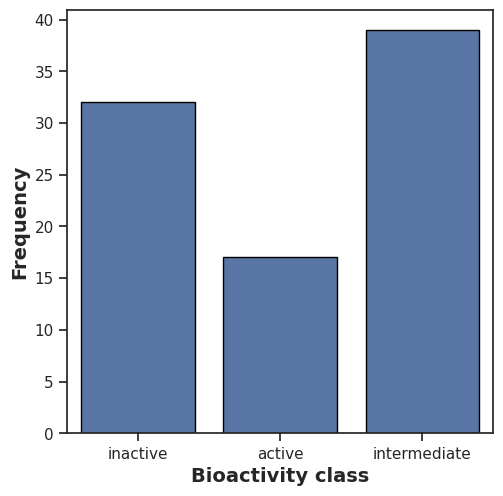

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

**Scatter plot of MW versus LogP**

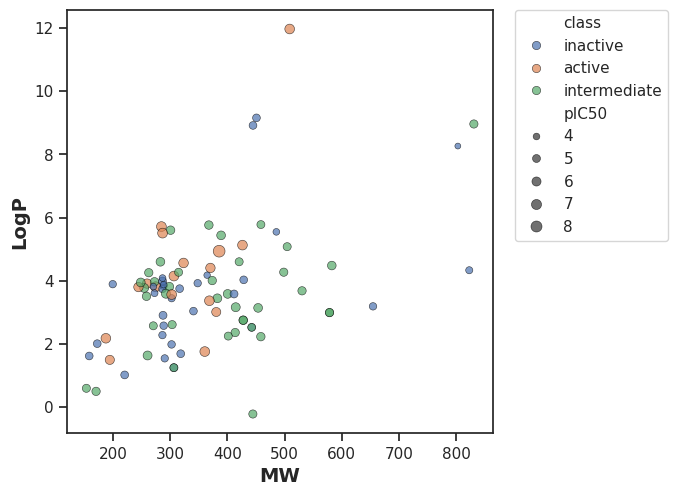

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

**Box plots**

pIC50 value

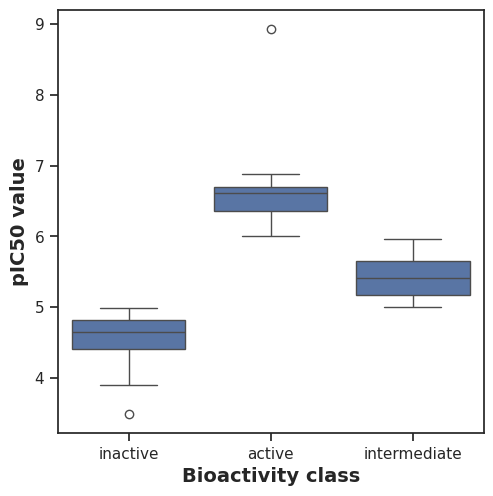

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='pIC50', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**MW**

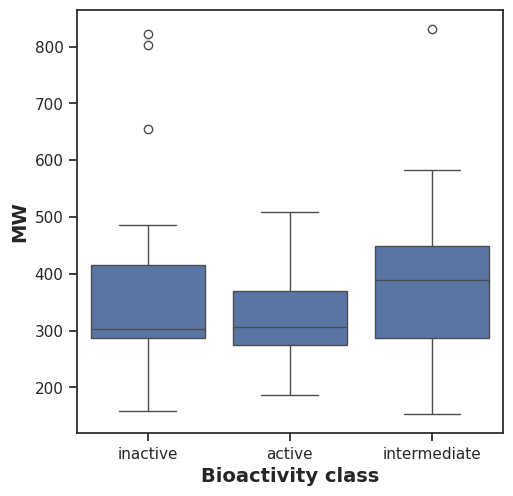

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='MW', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

**LogP**

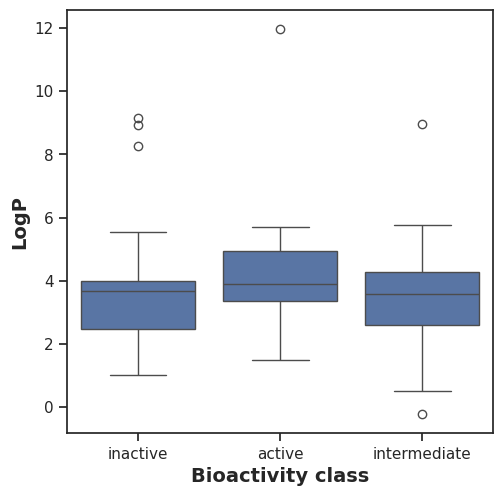

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**NumHDonors**

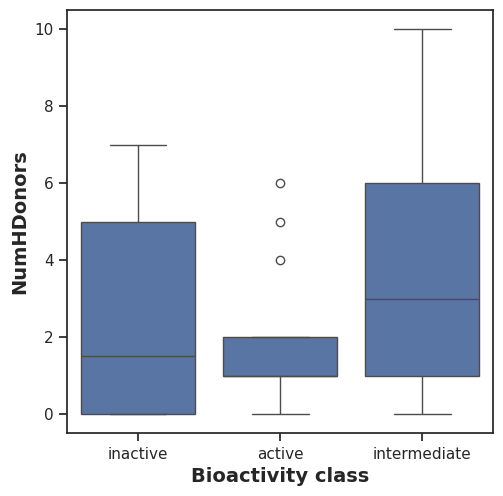

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**NumHAcceptors**

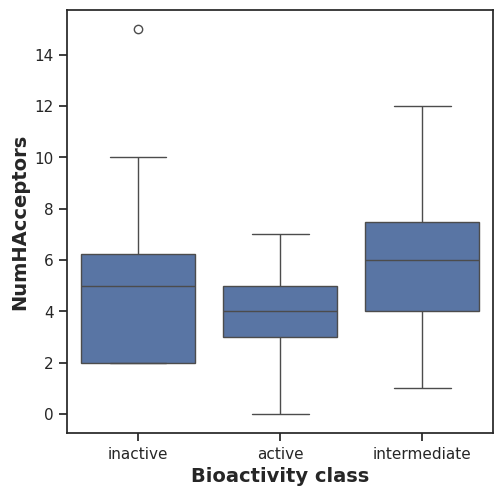

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

### Compute the Padel discriptor

*   download padel.zip and padel.sh from github downloadable links
*   upzip the zip file
*   create a dataframe with canonical_smiles and molecule_id
*   save the file to csv without header or index as [ .smi ] file
*   run the .sh file using bash command

In [ ]:
# install PaDEL library
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

--2024-10-31 18:04:59--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2024-10-31 18:04:59--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M   164MB/s    in 0.2s    

2024-10-31 18:05:00 (164 MB/s) - ‘padel.zip’ saved [25768637/25768637]



In [ ]:
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2024-10-31 18:05:05--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2024-10-31 18:05:05--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: ‘padel.sh’

padel.sh            100%[===================>]     231  --.-KB/s    in 0s      

2024-10-31 18:05:05 (5.22 MB/s) - ‘padel.sh’ saved [231/231]



In [ ]:
!unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
!cat molecule.smi | head -5
!cat molecule.smi | wc -l

c1ccc2c(c1)Nc1ccccc1S2	CHEMBL828
CN(C)CCC(=O)NN1c2ccccc2Sc2cc(Cl)ccc21	CHEMBL1629795
CN1CCN(NCCN2c3ccccc3Sc3ccccc32)CC1	CHEMBL3142202
COc1ccc2c(c1)Sc1cc(OC)ccc1N2	CHEMBL2063785
COc1ccc2c(c1)Sc1cc(C#N)ccc1N2	CHEMBL2063786
88


In [ ]:
!cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
# Compute PaDEL for the dataset
!bash padel.sh

Processing CHEMBL1629795 in molecule.smi (2/88). 
Processing CHEMBL828 in molecule.smi (1/88). 
Processing CHEMBL3142202 in molecule.smi (3/88). Average speed: 2.38 s/mol.
Processing CHEMBL2063785 in molecule.smi (4/88). Average speed: 1.27 s/mol.
Processing CHEMBL2063786 in molecule.smi (5/88). Average speed: 1.06 s/mol.
Processing CHEMBL2063787 in molecule.smi (6/88). Average speed: 0.83 s/mol.
Processing CHEMBL1976750 in molecule.smi (7/88). Average speed: 0.77 s/mol.
Processing CHEMBL2063789 in molecule.smi (9/88). Average speed: 0.64 s/mol.
Processing CHEMBL2063788 in molecule.smi (8/88). Average speed: 0.66 s/mol.
Processing CHEMBL2063790 in molecule.smi (10/88). Average speed: 0.57 s/mol.
Processing CHEMBL2063791 in molecule.smi (11/88). Average speed: 0.60 s/mol.
Processing CHEMBL2063792 in molecule.smi (12/88). Average speed: 0.55 s/mol.
Processing CHEMBL2063793 in molecule.smi (13/88). Average speed: 0.57 s/mol.
Processing CHEMBL2063794 in molecule.smi (14/88). Average speed:

In [ ]:
# Read the saved PaDEL descriptors in the file named "descriptors_output"
PaDEL = pd.read_csv('/content/descriptors_output.csv')
PaDEL = PaDEL.drop(columns=['Name'])

### Dimension Reduction Technique : VarianceThreshold

In [ ]:
selection = VarianceThreshold()
print("Before", PaDEL.shape)
PaDEL = selection.fit_transform(PaDEL)
print("After", PaDEL.shape)

Before (88, 881)
After (88, 442)


### Prepare the output/input dataframes

*   **Input:** PaDEL descriptors
*   **Output:** pIC50 value

In [ ]:
input = PaDEL.copy()
output = pd.DataFrame(df["pIC50"], columns=["pIC50"])

In [ ]:
input_ = pd.DataFrame(input)

<Axes: >

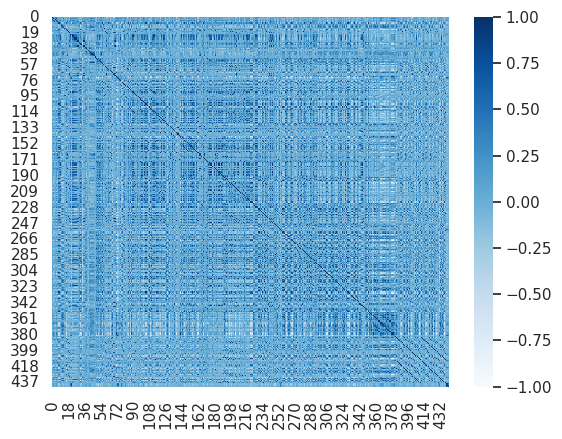

In [ ]:
sns.heatmap(input_.corr(), vmin=-1, vmax=1, cmap="Blues")

In [ ]:
input_.describe()

,0,1,2,3,4,5,6,7,8,9,...,432,433,434,435,436,437,438,439,440,441
count,88.00,88.00,88.00,88.00,88.00,88.00,88.00,88.00,88.00,88.00,...,88.00,88.00,88.00,88.00,88.00,88.00,88.00,88.00,88.00,88.00
mean,0.95,0.56,0.08,0.99,0.62,0.06,0.61,0.53,0.11,0.94,...,0.27,0.09,0.39,0.07,0.24,0.01,0.03,0.06,0.03,0.01
std,0.21,0.50,0.27,0.11,0.49,0.23,0.49,0.50,0.32,0.23,...,0.45,0.29,0.49,0.25,0.43,0.11,0.18,0.23,0.18,0.11
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,...,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Split the data to training and testing
X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.30, random_state=3)

## Apply Machine Learning Algorithms

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:10<00:00,  3.97it/s]


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 88
[LightGBM] [Info] Start training from score 5.284412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

100%|██████████| 42/42 [00:12<00:00,  3.33it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 88
[LightGBM] [Info] Start training from score 5.284412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[(0.0, 1.0)]

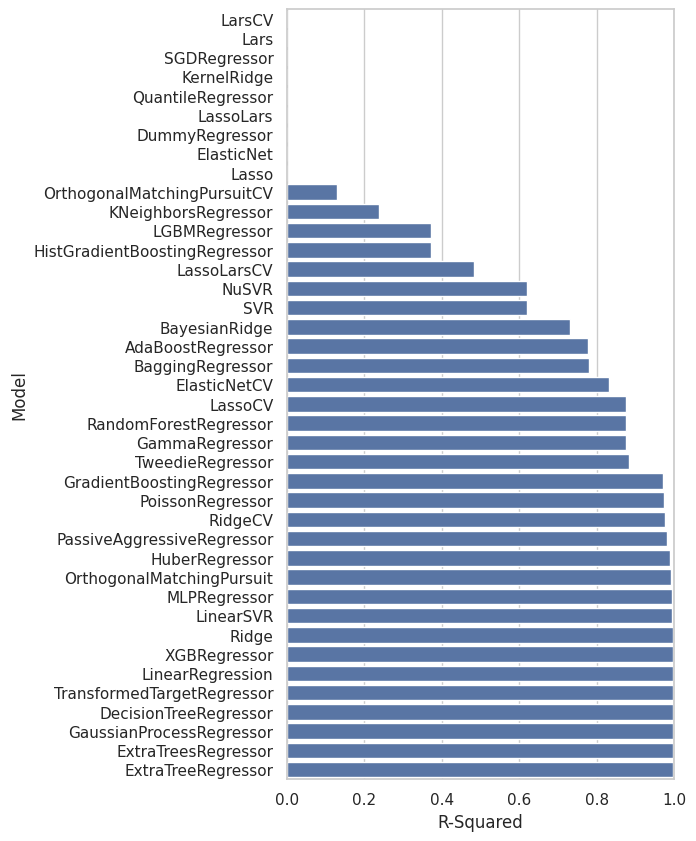

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

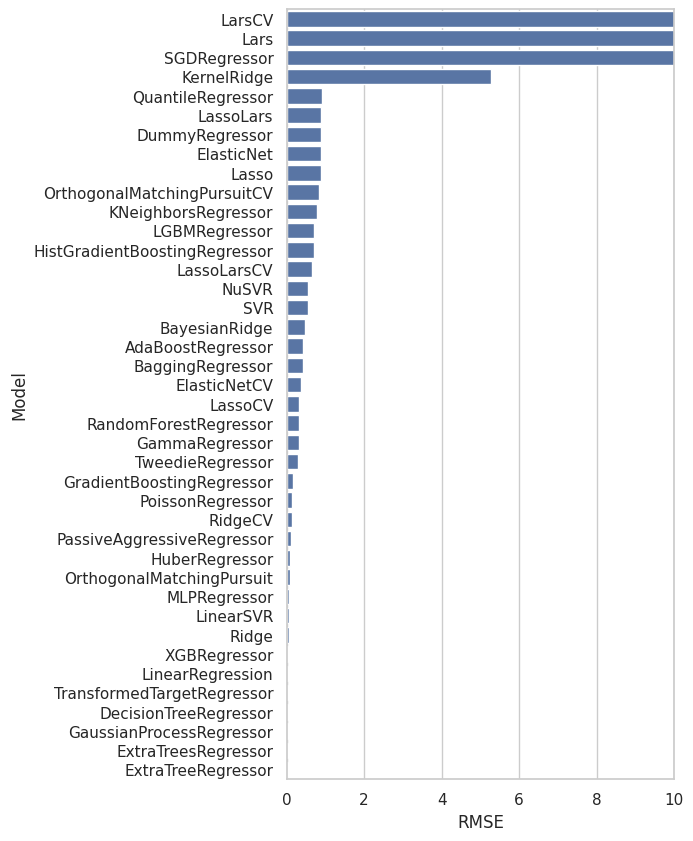

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

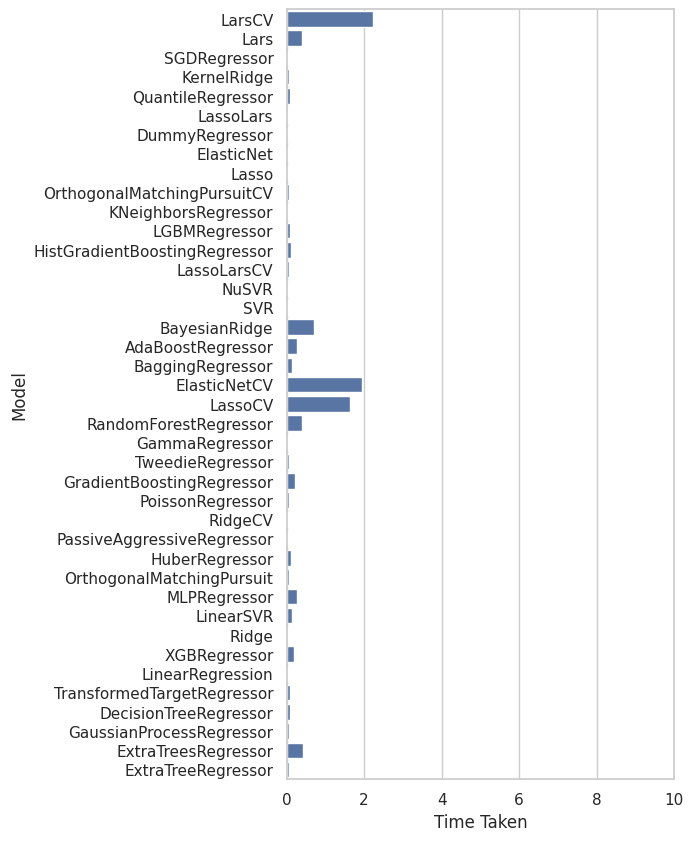

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))

In [ ]:
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [00:11<00:00,  3.60it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 61, number of used features: 88
[LightGBM] [Info] Start training from score 5.284412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
print(models)

                                                  Adjusted R-Squared  \
Model                                                                  
LarsCV                        17983843697539753355472400629628928.00   
Lars                          17983843697539753355472400629628928.00   
LinearRegression                               383197072540821760.00   
TransformedTargetRegressor                     383197072540821760.00   
SGDRegressor                                                 2670.01   
KernelRidge                                                     5.25   
GaussianProcessRegressor                                        4.63   
OrthogonalMatchingPursuit                                       1.29   
MLPRegressor                                                    1.24   
LinearSVR                                                       1.13   
Ridge                                                           1.12   
HuberRegressor                                                  

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
model1 = ExtraTreesRegressor(n_estimators=100, random_state=0)
model1.fit(X_train, Y_train)
r2_model1 = model1.score(X_test, Y_test)
print(r2_model1)
start = time.time()
Y_pred = model1.predict(X_test)
end = time.time()
print(end - start)
mae1=mean_absolute_error(Y_pred, Y_test)
print(mae1)
r21 = r2_score(Y_test, y_predict)
print(r21)

-0.5030532713494795
0.005250692367553711
0.640759464156663
-1.2311884345313575


In [ ]:
n_estimators = [10, 100, 300, 500, 800]
max_depth = [5, 8, 15, 25, 30]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(model1, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_test, Y_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
bestF.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [ ]:
n_estimators = [10, 100, 300, 500, 800]
max_depth = [5, 8, 15, 25, 30]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(model1, hyperF, cv = 3, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [ ]:
bestF.best_params_

{'max_depth': 5, 'n_estimators': 800}

In [ ]:
Opt = ExtraTreesRegressor(random_state = 1, max_depth = 5,n_estimators = 800)
modelOpt = Opt.fit(X_train, Y_train)
y_pred = modelOpt.predict(X_test)
r2_forestOpt = forestOpt.score(X_test, Y_test)
print(r2_forestOpt)
start = time.time()
Y_pred = forestOpt.predict(X_test)
end = time.time()
print(end - start)
maeOpt=mean_absolute_error(y_pred, Y_test)
print(maeOpt)
r2Opt = r2_score(Y_test, y_predict)
print(r2Opt)

0.9049768831682502
0.006468296051025391
0.7976075900553988
-1.2311884345313575


**Models will be built:**

In [ ]:
# Regression models
mdl_knr = KNeighborsRegressor()
mdl_svr = SVR()
mdl_dtr = DecisionTreeRegressor()
mdl_rfr = RandomForestRegressor()
mdl_abr = AdaBoostRegressor()
mdl_br = BaggingRegressor()
mdl_gbr = GradientBoostingRegressor()
mdl_hgbr = HistGradientBoostingRegressor()
mdl_lr = LinearRegression()
mdl_mlpr = MLPRegressor()

In [ ]:
list_mdl = [mdl_knr, mdl_svr, mdl_dtr, mdl_rfr, mdl_abr, mdl_br, mdl_gbr, mdl_hgbr, mdl_lr, mdl_mlpr]
names_mdl = ["KNR","SVR","Decision Tree","Random Forest","Ada Boost","Bagging","Gradient Boosting","Hist Gradient Boosting","Linear Regressor", "Multilayer Perceptron"]
y_mdl_pred = list()

In [ ]:
print("{:>25} {:>10}".format(*["MODEL","SCORE"]))
for n, mdl in enumerate(list_mdl):
    mdl.fit(X_train, Y_train)
    y_predict = mdl.predict(X_test)
    score = r2_score(Y_test, y_predict)
    show_values = [names_mdl[n],  np.round(score,2)]
    print("{:>25} {:>10}".format(*show_values))

                    MODEL      SCORE
                      KNR      -0.31
                      SVR      -0.14
            Decision Tree      -0.66
            Random Forest       0.25
                Ada Boost       0.03
                  Bagging       0.26
        Gradient Boosting       0.25
   Hist Gradient Boosting      -0.45
         Linear Regressor -6.196047943930143e+23
    Multilayer Perceptron      -1.23


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ..................max_features=20, n_estimators=190; total time=   0.7s
[CV] END ..................max_features=20, n_estimators=190; total time=   0.7s
[CV] END ..................max_features=20, n_estimators=190; total time=   0.7s
[CV] END ..................max_features=20, n_estimators=192; total time=   0.6s
[CV] END ..................max_features=20, n_estimators=192; total time=   0.4s
[CV] END ..................max_features=20, n_estimators=192; total time=   0.4s
[CV] END ..................max_features=20, n_estimators=194; total time=   0.4s
[CV] END ..................max_features=20, n_estimators=194; total time=   0.4s
[CV] END ..................max_features=20, n_estimators=194; total time=   0.4s
[CV] END ..................max_features=20, n_estimators=196; total time=   0.4s
[CV] END ..................max_features=20, n_estimators=196; total time=   0.4s
[CV] END ..................max_features=20, n_e

ValueError: x and y must have same first dimension, but have shapes (20,) and (50,)

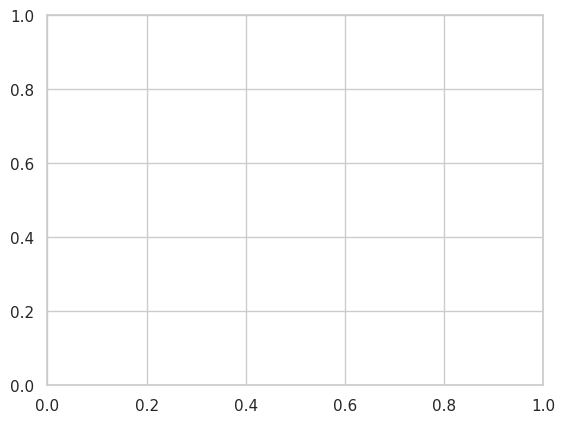

In [ ]:
#Ejemplo de bagging
from sklearn.ensemble import BaggingRegressor

max_features = range(20,30,2)
n_estimators = range(190,210,2)
#param_grid = {'max_depth': maxDepth} --> esto falla
param_grid = {'max_features' : max_features,
              'n_estimators' : n_estimators}
grid = GridSearchCV(BaggingRegressor(DecisionTreeRegressor(), random_state = 0), param_grid = param_grid, cv = 3, verbose = 2)
grid.fit (X_train, Y_train)
print (grid.best_score_)
print (grid.best_params_)

#Ejemplo de bagging
scores = np.array (grid.cv_results_ ['mean_test_score'])
plt.plot (maxDepth, scores, 'o')
plt.xlabel ('max_depth', fontsize = 16)
plt.ylabel ('10-Fold MSE')
#plt.ylim (-1, 0)
plt.show

In [ ]:
grid.cv_results_

{'mean_fit_time': array([0.38651713, 0.37566876, 0.3765897 , 0.37996014, 0.5046587 ,
        0.64403645, 0.44236978, 0.38583938, 0.3842903 , 0.3864545 ,
        0.39229496, 0.39580512, 0.39258059, 0.38950936, 0.61159913,
        0.66732868, 0.40085498, 0.38731098, 0.39646109, 0.40114482]),
 'std_fit_time': array([0.00170012, 0.0051315 , 0.01033451, 0.00333661, 0.09365775,
        0.02823107, 0.08352084, 0.00555357, 0.00553753, 0.01027916,
        0.01079407, 0.02890443, 0.0198926 , 0.00943142, 0.05201256,
        0.00538157, 0.01373526, 0.01224998, 0.00649634, 0.0054648 ]),
 'mean_score_time': array([0.02962732, 0.02823639, 0.02988585, 0.03483311, 0.0427285 ,
        0.04705683, 0.02885191, 0.0289522 , 0.03572671, 0.02980789,
        0.02910868, 0.03161581, 0.02914015, 0.02755555, 0.0515101 ,
        0.05108396, 0.0276893 , 0.03038065, 0.02882282, 0.02966404]),
 'std_score_time': array([0.00369812, 0.00178059, 0.0011754 , 0.00516128, 0.01223668,
        0.00091234, 0.00277054, 0.002189